In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [7]:
global image_h
global image_w
global num_classes
global classes
global rgb_codes


# def grayscale_to_rgb(mask, rgb_codes):
#     h, w = mask.shape[0], mask.shape[1]
#     mask = mask.astype(np.int32)
#     output = []

#     for i, pixel in enumerate(mask.flatten()):
#         output.append(rgb_codes[pixel])

#     output = np.reshape(output, (h, w, 3))
#     return output

def face_skin_extract(pred,image_x):
    output = np.zeros_like(image_x, dtype=np.uint8)
    mask = (pred == 1) | (pred == 6)
    # mask = (pred==1)
    output[mask] = image_x[mask]
    return output

# def save_results(image_x, mask, pred, save_image_path):
#     mask = np.expand_dims(mask, axis=-1)
#     mask = grayscale_to_rgb(mask, rgb_codes)

#     pred = np.expand_dims(pred, axis=-1)
#     pred = grayscale_to_rgb(pred, rgb_codes)

#     line = np.ones((image_x.shape[0], 10, 3)) * 255

#     cat_images = np.concatenate([image_x, line, mask, line, pred], axis=1)
#     cv2.imwrite(save_image_path, cat_images)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)


    """ Hyperparameters """
    image_h = 512
    image_w = 512
    num_classes = 11

    """ Paths """
    model_path = "10epoch model.h5"

    """ RGB Code and Classes """
    # rgb_codes = [
    #     [0, 0, 0], [0, 153, 255], [102, 255, 153], [0, 204, 153],
    #     [255, 255, 102], [255, 255, 204], [255, 153, 0], [255, 102, 255],
    #     [102, 0, 51], [255, 204, 255], [255, 0, 102]
    # ]


    classes = [
        "background", "skin", "left eyebrow", "right eyebrow",
        "left eye", "right eye", "nose", "upper lip", "inner mouth",
        "lower lip", "hair"
    ]

    model = tf.keras.models.load_model(model_path)

    x = "blackgal.jpg"
    # y = "/kaggle/input/lapa-face-parsing-dataset/LaPa/test/labels/10012551673_5.png"

    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_w, image_h))
    image_x = image
    image = image/255.0 ## (H, W, 3)
    image = np.expand_dims(image, axis=0) ## [1, H, W, 3]
    image = image.astype(np.float32)

    # mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    # mask = cv2.resize(mask, (image_w, image_h))
    # mask = mask.astype(np.int32)


    pred = model.predict(image, verbose=0)[0]
    pred = np.argmax(pred, axis=-1) ## [0.1, 0.2, 0.1, 0.6] -> 3
    pred = pred.astype(np.int32)

    # rgb_mask = grayscale_to_rgb(pred, rgb_codes)
    face_skin = face_skin_extract(pred,image_x)
    
    # cv2.imwrite("pred.png", rgb_mask)
    cv2.imwrite("face_skin.png",face_skin)

    # save_image_path = "/kaggle/working/1.png"
    # save_results(image_x, mask, pred, save_image_path)


Original Image


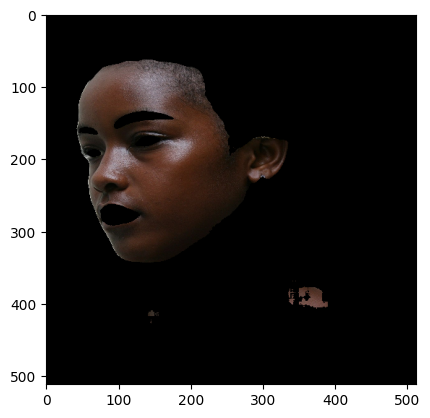

Original Image after Histogram eq.


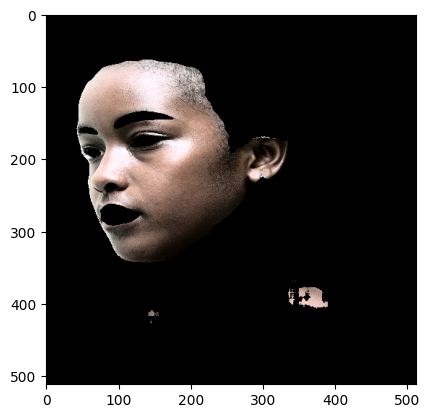

Grayscale Image


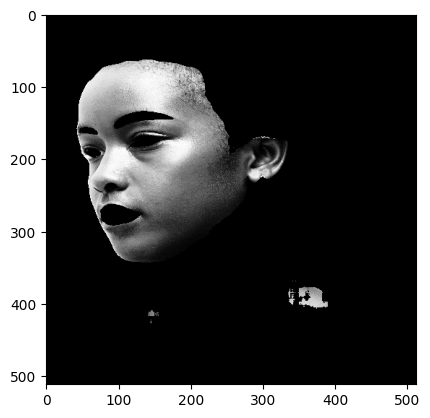

After segmentation using Otsu's method.


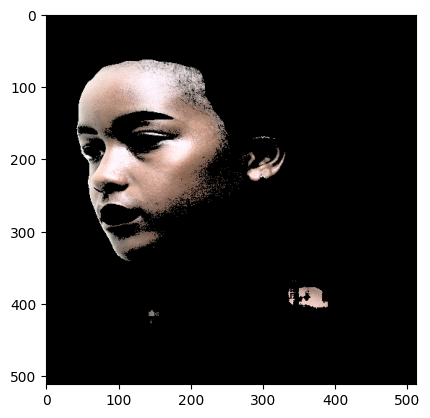

HSV space


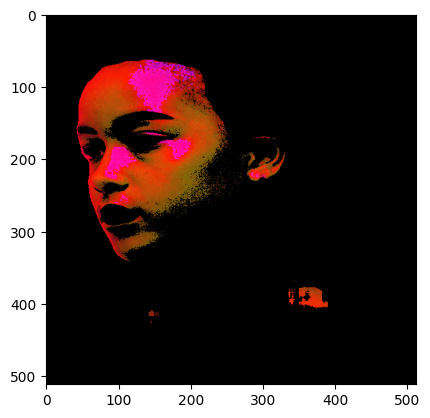

YCrCb space


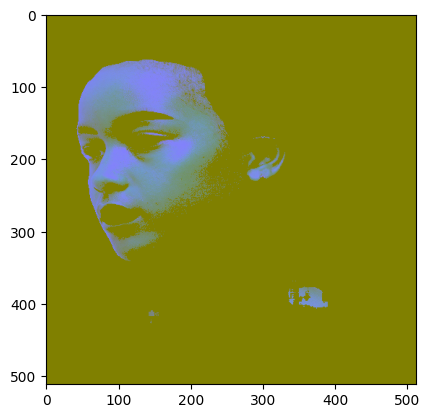

After masking


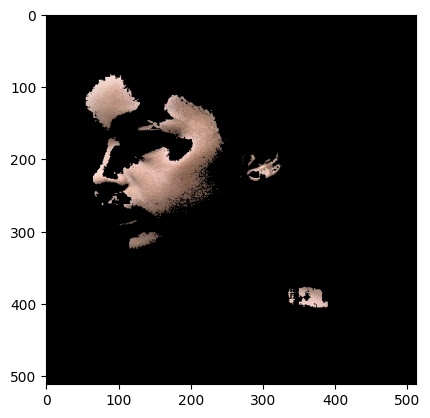

Final average skin tone RGB: 180.8359335961357, 146.6001887735273, 132.65709843984231


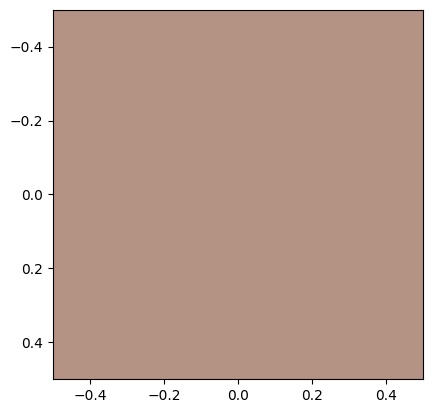

In [2]:

def run_histogram_equalization(img_bgr):

    img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    img_ycrcb[:, :, 0] = cv2.equalizeHist(img_ycrcb[:, :, 0])
    img_bgr = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2BGR)
    return img_bgr


def segment_otsu(image_grayscale, img_BGR):
    """Segment using otsu binarization and thresholding."""
    threshold_value, threshold_image = cv2.threshold(image_grayscale, 0, 255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    threshold_image_binary = 1 - (threshold_image / 255)
    threshold_image_binary = np.repeat(threshold_image_binary[:, :, np.newaxis], 3, axis=2)
    img_face_only = np.multiply(threshold_image_binary, img_BGR).astype('uint8')
    return img_face_only

img_bgr = cv2.imread('face_skin.png')
print("Original Image")
plt.imshow(img_bgr[:, :, ::-1])
plt.show()

print("Original Image after Histogram eq.")
img_bgr = run_histogram_equalization(img_bgr)
plt.imshow(img_bgr[:, :, ::-1])
plt.show()

print("Grayscale Image")
img_grayscale = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
plt.imshow(img_grayscale, cmap='gray')
plt.show()

print("After segmentation using Otsu's method.")
img_bgr = segment_otsu(img_grayscale, img_bgr)
plt.imshow(img_bgr[:, :, ::-1])
plt.show()

print("HSV space")
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
plt.imshow(img_hsv[:, :, ::-1])
plt.show()

print("YCrCb space")
img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
plt.imshow(img_ycrcb[:, :, ::-1])
plt.show()
    
mask = (img_hsv[:, :, 0] <= 170) & \
    (img_ycrcb[:, :, 1] >= 140) & \
    (img_ycrcb[:, :, 1] <= 170) & \
    (img_ycrcb[:, :, 2] >= 90) & \
    (img_ycrcb[:, :, 2] <= 120)

print("After masking")
img_bgr[~mask] = 0
plt.imshow(img_bgr[:, :, ::-1])
plt.show()

blue = np.ma.array(img_bgr[:, :, 0], mask=~mask).mean()
green = np.ma.array(img_bgr[:, :, 1], mask=~mask).mean()
red = np.ma.array(img_bgr[:, :, 2], mask=~mask).mean()

print(f"Final average skin tone RGB: {red}, {green}, {blue}")
plt.imshow([[[x / 255 for x in [red, green, blue]]]])
plt.show()

Cluster Percentages: {np.int32(0): np.float64(0.49), np.int32(1): np.float64(0.35), np.int32(2): np.float64(0.16)}
Cluster Centers (RGB): [[171.67242152 135.39603886 131.74835575]
 [123.62055618 100.04940409 102.67647958]
 [241.31023622 233.12418448 232.16760405]]
0.49
[171.67242152 135.39603886 131.74835575]


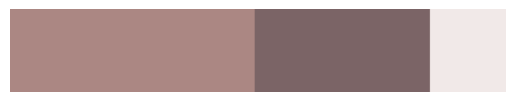

In [12]:
from collections import Counter
from sklearn.cluster import KMeans

# Load and convert the image to RGB
img = cv2.imread("face_skinq.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mask to exclude black pixels
mask = ~np.all(img == [0, 0, 0], axis=-1)

# Extract non-black pixels
non_black_pixels = img[mask]

# Apply KMeans clustering on non-black pixels
clt = KMeans(n_clusters=3, n_init="auto")
clt.fit(non_black_pixels)

def palette_perc(k_cluster):

    width = 300
    palette = np.zeros((50, width, 3), dtype=np.uint8)
    
    # Count the pixels per cluster
    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_)
    
    # Calculate percentages for each cluster
    perc = {i: np.round(counter[i] / n_pixels, 2) for i in counter}
    perc = dict(sorted(perc.items()))

    cluster_centers = k_cluster.cluster_centers_
    
    # Logging purposes
    print("Cluster Percentages:", perc)
    print("Cluster Centers (RGB):", cluster_centers)

    val = list(perc.values())
    val.sort()
    res = val[-1]
    print(res)
    sec_high_val = list(perc.keys())[list(perc.values()).index(res)]
    rgb_list = cluster_centers[sec_high_val]
    # Create the palette
    step = 0
    for idx, center in enumerate(k_cluster.cluster_centers_):
        # Fill the palette with the cluster's color
        width_step = int(perc[idx] * width + 1)
        palette[:, step:step + width_step, :] = center
        step += width_step
    
    return palette,rgb_list

# Generate and display the palette
palette,rgb_list = palette_perc(clt)
print(rgb_list)
plt.imshow(palette)
plt.axis("off")
plt.show()

In [14]:
from webcolors import hex_to_rgb, rgb_to_hex
from scipy.spatial import KDTree

def closest_tone_match(rgb_tuple):
    skin_tones = {'Monk 10': '#292420', 'Monk 9': '#3a312a', 'Monk 8':'#604134', 'Monk 7':'#825c43', 'Monk 6':'#a07e56', 'Monk 5':'#d7bd96', 'Monk 4':'#eadaba', 'Monk 3':'#f7ead0', 'Monk 2':'#f3e7db', 'Monk 1':'#f6ede4'}

    rgb_values = []
    names = []
    for monk in skin_tones:
        names.append(monk)
        rgb_values.append(hex_to_rgb(skin_tones[monk]))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)

    return names[index]

match = closest_tone_match((rgb_list[0],rgb_list[1],rgb_list[2]))
# match = closest_tone_match((41,26,16))
print(match)

Monk 6
